# Multilingual Image Captioning with Voice Assistance


In [1]:
#Import all the required libraries
!pip install wordcloud
!pip install gTTs
!pip install playsound

import glob
import os

#from glob import glob
import pickle
from pickle import dump,load
from sys import getsizeof
# Date and Time 
import datetime,time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)

from skimage import io
pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


#Read/Display  images
from skimage import io
from PIL import Image
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import Input, layers, Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import keras
from keras.preprocessing.text import Tokenizer


from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D,Bidirectional,Add

#from keras.layers.wrappers import Bidirectional
#from keras.layers.wrappers import Bidirectional
from keras import optimizers
#from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

from gtts import gTTS
from IPython.display import Audio
from playsound import playsound
from IPython import display

import warnings
warnings.filterwarnings("ignore")

C:\Users\admin\AppData\Local\Temp\ipykernel_8244\2407427599.py:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


In [2]:
 tf. __version__

'2.12.0'

In [3]:
## Check GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5676273505336637755
xla_global_id: -1
]


read the dataset

## Data understanding
1.Importing the dataset and read image & captions into two seperate variables

2.Visualising both the images & text present in the dataset

3.Creating a dataframe which summarizes the image, path & captions as a dataframe

4.Creating a list which contains all the captions & path

5.Visualising the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable
DATA_DIR = "./Filckr_small_1000/"
images=os.path.join(DATA_DIR,'Images')

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 1000


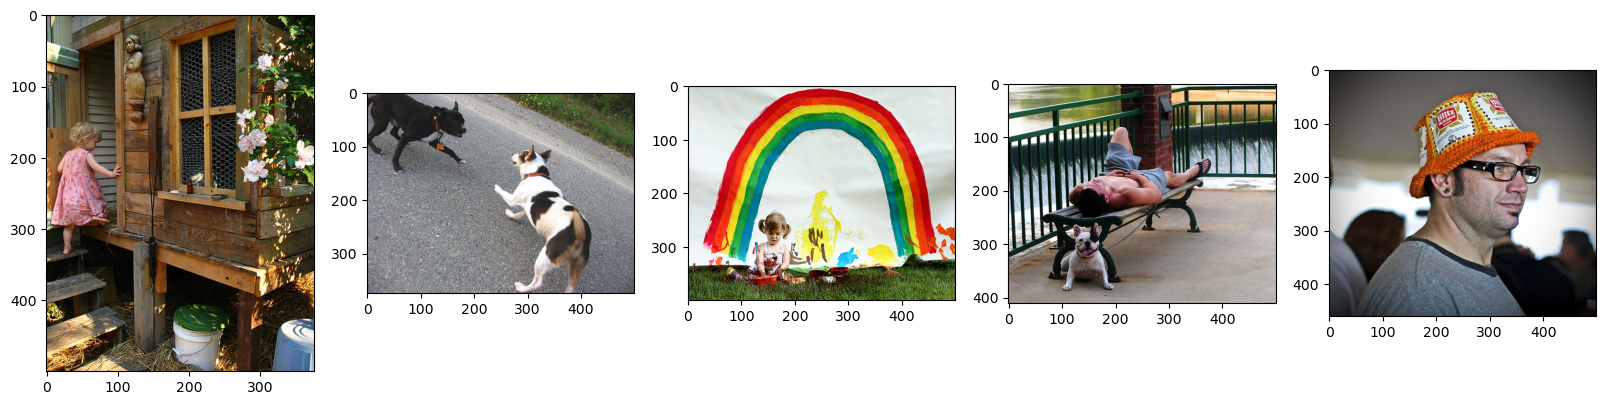

In [5]:
#Visualise both the images & text present in the dataset
Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)


In [6]:
#Import the dataset and read the text file into a seperate variable
text_file = './Filckr_small/captions.txt'
def load_doc(filename):
    
    #your code here
    open_file = open(text_file, 'r', encoding="latin-1") #associate and returns a file object
    text = open_file.read() #for reading the content of the file
    print(text)
    open_file.close()    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
image_path='./Filckr_small_1000/Images/'
INPUT_PATH='./Capstone/'
all_img_id= [] #store all the image id here
all_img_vector=[] #store all the image path here
annotations=[] #store all the captions here
with open('./Filckr_small_1000/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
994  1240297429_c36ae0c58f.jpg   
995  124195430_d14028660f.jpg    
996  124195430_d14028660f.jpg    
997  124195430_d14028660f.jpg    
998  124195430_d14028660f.jpg    

                                                     Path  \
0    ./Filckr_small_1000/Images/1000268201_693b08cb0e.jpg   
1    ./Filckr_small_1000/Images/1000268201_693b08cb0e.jpg   
2    ./Filckr_small_1000/Images/1000268201_693b08cb0e.jpg   
3    ./Filckr_small_1000/Images/1000268201_693b08cb0e.jpg   
4    ./Filckr_small_1000/Images/1000268201_693b08cb0e.jpg   
..                                                    ...   
994  ./Filckr_small_1000/Images/1240297429_c36ae0c58f.jpg   
995  ./Filckr_small_1000/Images/124195430_d14028660f.jpg    
996  ./Filckr_small_1000/Images/124195430_d14028660f.jpg    
997  ./Filckr_small_1000/Images/124195430_d14028660f.jpg    
998  ./Filckr_small_1000/Images/124195430_d14028660f.jpg    

                                                                             Captions  
0    A child in a pink dress is climbing up a set of stairs in an entry way            
1    A girl going into a wooden building                                               
2    A little girl climbing into a wooden playhouse                                    
3    A little girl climbing the stairs to her playhouse                                
4    A little girl in a pink dress going into a wooden cabin                           
..                                                        ...                          
994  The dog in a vest leaps in the air and there is a bird flying                     
995  A brown horse and a black foal on the beach                                       
996  A brown horse stands near a black horse that is sitting on the ground             
997  A large brown horse stands over a small black colt that is kneeling on the sand   
998  An adult horse approaching a foal on a sandy plain                                

[999 rows x 3 columns]

In [8]:
type(annotations)

list

In [9]:
len(annotations)

999

In [10]:
#Create a list which contains all the captions
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations] 

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=all_img_vector

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 999
Total images present in the dataset: 999


In [11]:
annotations[0:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

In [12]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for line in annotations for word in line.split()] 

val_count=Counter(vocabulary)
val_count

Counter({'<start>': 999,
         'A': 569,
         'child': 54,
         'in': 441,
         'a': 1002,
         'pink': 9,
         'dress': 9,
         'is': 239,
         'climbing': 28,
         'up': 37,
         'set': 4,
         'of': 172,
         'stairs': 2,
         'an': 51,
         'entry': 1,
         'way': 4,
         '<end>': 999,
         'girl': 92,
         'going': 4,
         'into': 48,
         'wooden': 8,
         'building': 13,
         'little': 53,
         'playhouse': 2,
         'the': 371,
         'to': 79,
         'her': 23,
         'cabin': 1,
         'black': 86,
         'dog': 212,
         'and': 203,
         'spotted': 1,
         'are': 82,
         'fighting': 1,
         'tri-colored': 1,
         'playing': 57,
         'with': 176,
         'each': 12,
         'other': 18,
         'on': 289,
         'road': 11,
         'white': 80,
         'brown': 85,
         'spots': 1,
         'staring': 2,
         'at': 101,
         's

a :  1002
<start> :  999
<end> :  999
A :  569
in :  441
the :  371
on :  289
is :  239
dog :  212
and :  203
with :  176
of :  172
man :  169
boy :  119
at :  101
girl :  92
Two :  89
black :  86
brown :  85
are :  82
white :  80
young :  80
woman :  80
to :  79
water :  72
The :  65
running :  59
blue :  58
playing :  57
wearing :  56


Text(0, 0.5, 'Counts')

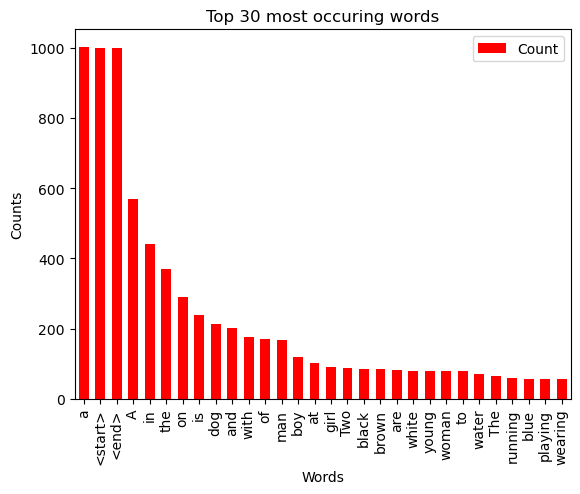

In [13]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")


## Pre-Processing the captions
1.Creating the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replacing all other words with the unknown token "UNK" .

3.Creating word-to-index and index-to-word mappings.

4.Pading all sequences to be the same length as the longest one.

In [14]:
# create the tokenizer

top_word_count = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count+1,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [15]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [16]:
train_seqs[:5]

[[3, 2, 30, 5, 2, 141, 153, 8, 65, 51, 2, 295, 13, 459, 5, 27, 645, 296, 4],
 [3, 2, 17, 297, 42, 2, 166, 113, 4],
 [3, 2, 32, 17, 65, 42, 2, 166, 460, 4],
 [3, 2, 32, 17, 65, 6, 459, 24, 72, 460, 4],
 [3, 2, 32, 17, 5, 2, 141, 153, 297, 42, 2, 166, 646, 4]]

In [17]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

In [18]:
tokenizer.oov_token

'<unk>'

In [19]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'dog',
 10: 'and',
 11: 'man',
 12: 'with',
 13: 'of',
 14: 'two',
 15: 'boy',
 16: 'at',
 17: 'girl',
 18: 'black',
 19: 'brown',
 20: 'young',
 21: 'woman',
 22: 'white',
 23: 'are',
 24: 'to',
 25: 'water',
 26: 'people',
 27: 'an',
 28: 'running',
 29: 'blue',
 30: 'child',
 31: 'playing',
 32: 'little',
 33: 'dogs',
 34: 'wearing',
 35: 'his',
 36: 'beach',
 37: 'front',
 38: 'sitting',
 39: 'through',
 40: 'jumping',
 41: 'while',
 42: 'into',
 43: 'three',
 44: 'shirt',
 45: 'red',
 46: 'down',
 47: 'pool',
 48: 'small',
 49: 'field',
 50: 'grass',
 51: 'up',
 52: 'person',
 53: 'ball',
 54: 'toy',
 55: 'standing',
 56: 'snow',
 57: 'yellow',
 58: 'by',
 59: 'near',
 60: 'rock',
 61: 'street',
 62: 'green',
 63: 'large',
 64: 'stands',
 65: 'climbing',
 66: 'sits',
 67: 'air',
 68: 'next',
 69: 'catch',
 70: 'holding',
 71: 'children',
 72: 'her',
 73: 'walking',
 74: 'another',
 75: '

In [20]:
tokenizer.word_counts

OrderedDict([('<start>', 999),
             ('a', 1597),
             ('child', 57),
             ('in', 441),
             ('pink', 10),
             ('dress', 9),
             ('is', 239),
             ('climbing', 28),
             ('up', 38),
             ('set', 4),
             ('of', 172),
             ('stairs', 2),
             ('an', 63),
             ('entry', 1),
             ('way', 4),
             ('<end>', 999),
             ('girl', 97),
             ('going', 4),
             ('into', 48),
             ('wooden', 8),
             ('building', 13),
             ('little', 56),
             ('playhouse', 2),
             ('the', 440),
             ('to', 79),
             ('her', 23),
             ('cabin', 1),
             ('black', 89),
             ('dog', 215),
             ('and', 203),
             ('spotted', 1),
             ('are', 82),
             ('fighting', 1),
             ('tri', 1),
             ('colored', 6),
             ('playing', 57),
            

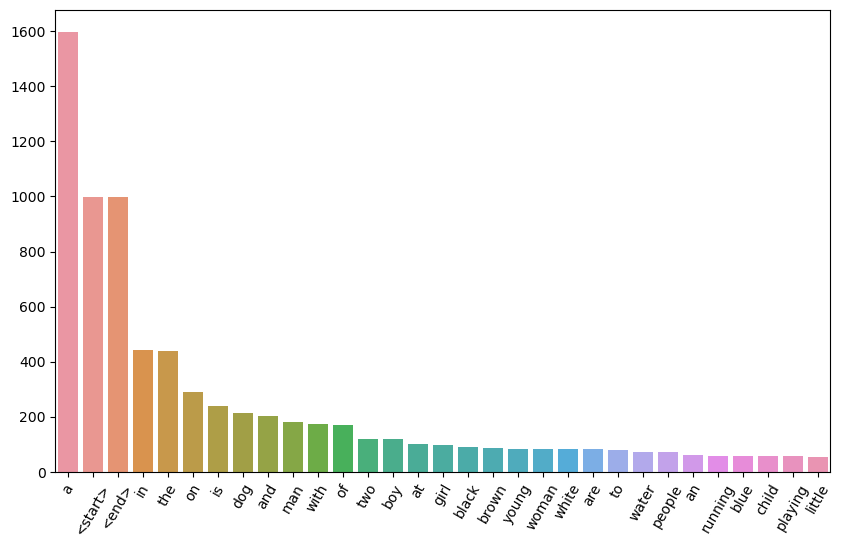

In [21]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()

get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [22]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='blue')

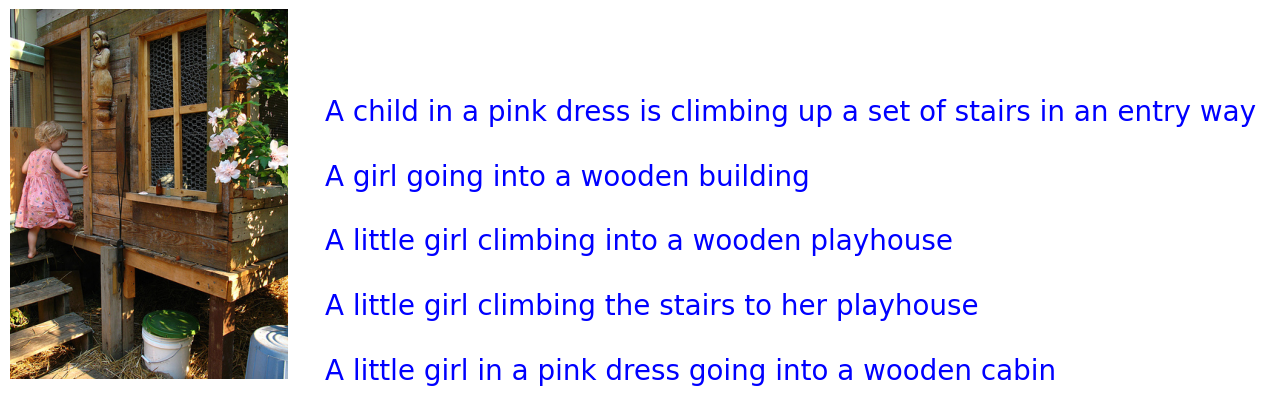

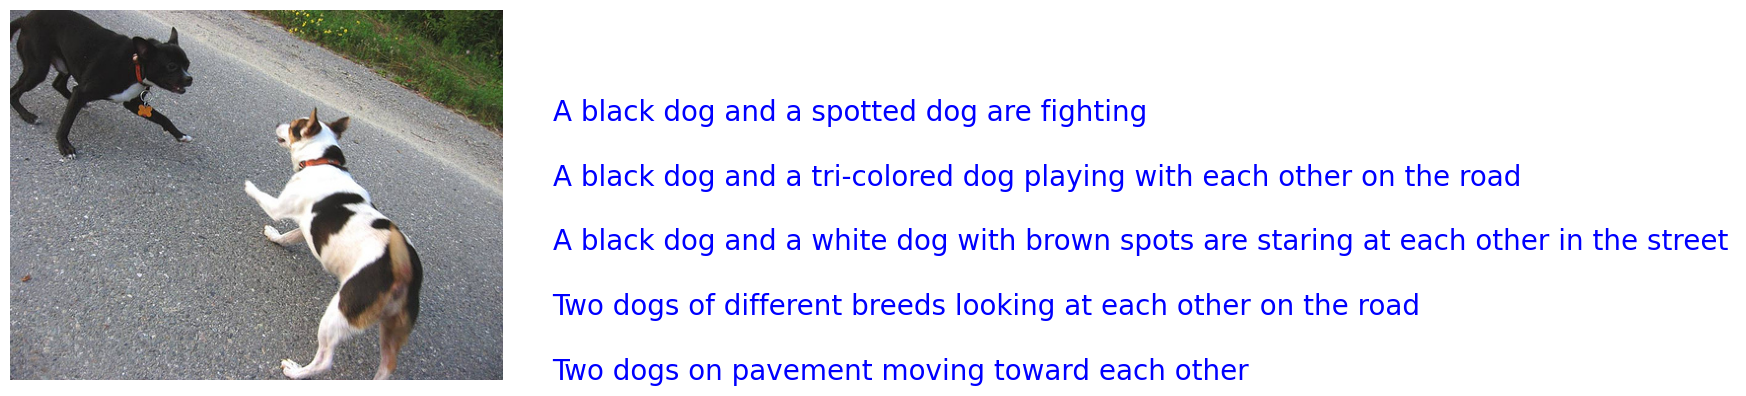

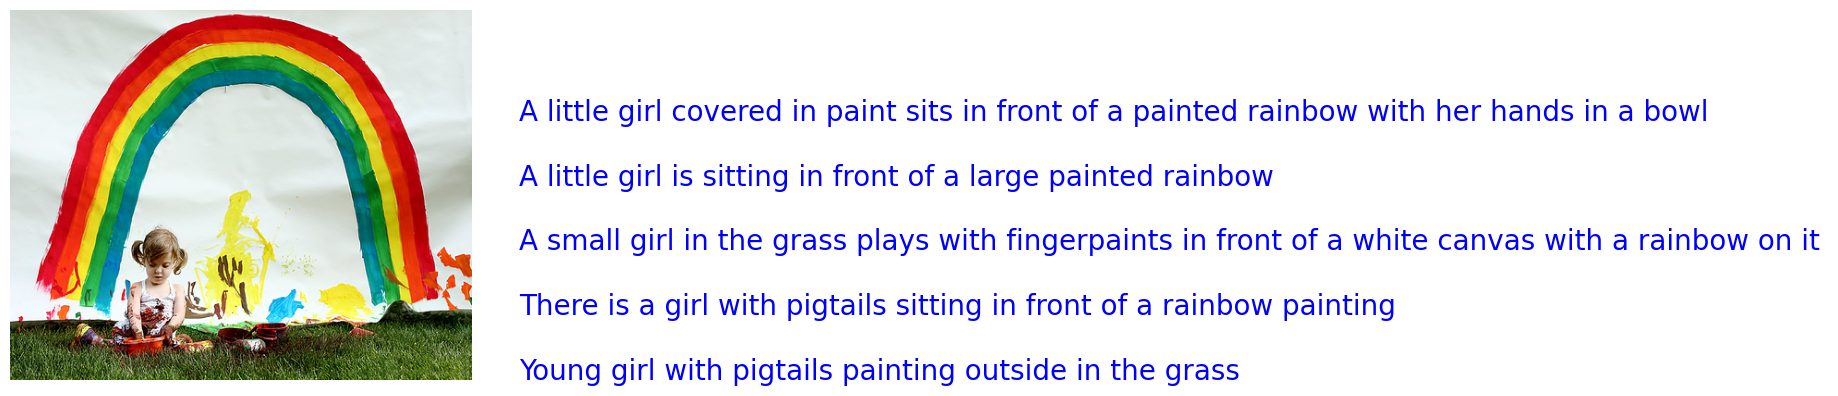

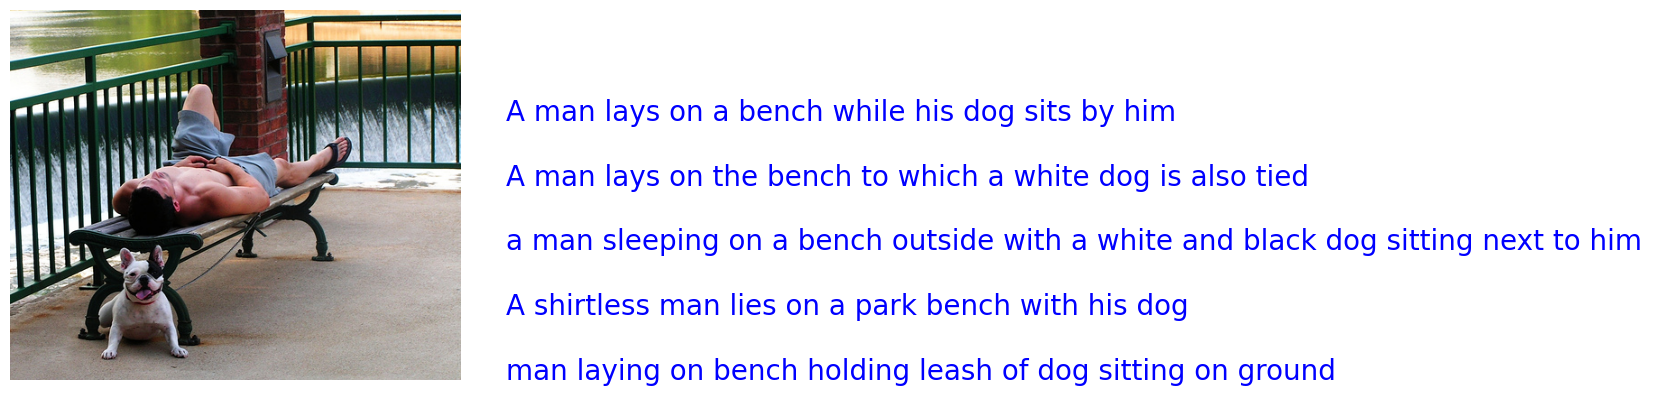

In [23]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,4,df)

In [24]:
# Function to find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_l= max_length

In [25]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector
caption_vector= padding_train_sequences(train_seqs,max_length,'post') #your code here

print("The shape of Caption vector is :" + str(caption_vector.shape))

The shape of Caption vector is :(999, 31)


In [26]:
caption_vector

array([[  3,   2,  30, ...,   0,   0,   0],
       [  3,   2,  17, ...,   0,   0,   0],
       [  3,   2,  32, ...,   0,   0,   0],
       ...,
       [  3,   2,  19, ...,   0,   0,   0],
       [  3,   2,  63, ...,   0,   0,   0],
       [  3,  27, 638, ...,   0,   0,   0]])

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

###  resize the images::
* Since we have a list which contains all the image path, we need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once we have created a dataset consisting of image paths, we need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [27]:

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)    
    return img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


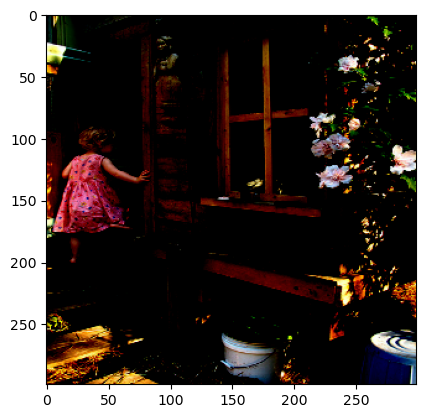

In [28]:

plt.imshow(load_image(all_img_path[0])[0])



In [29]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [30]:
image_data_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Using a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [31]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model =keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [32]:
image_features_extract_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [33]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:40<00:00,  5.78s/it]


In [34]:
batch_f.shape

TensorShape([64, 2048])

### store the features:
* I am storing the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* I am storing using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Applied train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Created a function which maps the image path to their feature. 

3.Created a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building is (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building is(batch_size, max_len)


In [35]:

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [36]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 799
Testing data for images: 200
Training data for Captions: 799
Testing data for Captions: 200


In [37]:
# Creating a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name,capt): # your input variable goes here):
  img_tensor = feature_dict[image_name.decode('utf-8')] 
  return img_tensor,capt

###  loading the features:
*loading the features using the dictionary created earlier OR
*storing using numpy(np.load) to load the feature vector.

In [38]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data): # input variables):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [39]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [40]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [41]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [42]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #self.dense = #build  Dense layer with relu activation
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)        
    def call(self, features):
        features = self.fc(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [43]:
encoder=Encoder(embedding_dim)

### Attention model

In [44]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =layers.Dense(units) #build Dense layer
        self.W2 = layers.Dense(units) #build Dense layer
        self.V = layers.Dense(1) #build final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =  keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  # build score funciton to shape: (batch_size, 8*8, units)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) # extract attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [45]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)  #build Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units) #build Dense layer
        self.d2 = layers.Dense(vocab_size) #build Dense layer
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create context vector & attention weights from attention model
        embed = self.dropout(self.embed(x))  # embed input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state =self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [47]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Creating checkpoint path

3.Creating training & testing step functions

4.Creating loss function for the test dataset

In [48]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define loss object

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [50]:
checkpoint_path_ckpt = INPUT_PATH +'checkpoint1/'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [52]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0])
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:      
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

* While creating the test step for model,I am passig previous prediciton as the next input to the decoder.

In [53]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
   
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0

   
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
    
        total_loss += t_loss
        avg_test_loss=total_loss/test_num_steps    
    return avg_test_loss

In [55]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()
# Save the encoder model after training
encoder.save('./FinalModels' + '/encoder_model')

# Save the decoder model after training
decoder.save('./FinalModels' + '/decoder_model')

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 2.304, & test loss is 2.300
Time taken for 1 epoch 296.503803730011 sec

Test loss has been reduced from 100.000 to 2.300


  7%|█████▎                                                                          | 1/15 [05:02<1:10:36, 302.58s/it]

For epoch: 2, the train loss is 1.956, & test loss is 2.143
Time taken for 1 epoch 47.1029908657074 sec

Test loss has been reduced from 2.300 to 2.143


 13%|██████████▉                                                                       | 2/15 [05:53<33:30, 154.64s/it]

For epoch: 3, the train loss is 1.828, & test loss is 1.999
Time taken for 1 epoch 41.59789180755615 sec

Test loss has been reduced from 2.143 to 1.999


 20%|████████████████▍                                                                 | 3/15 [06:39<20:57, 104.80s/it]

For epoch: 4, the train loss is 1.671, & test loss is 1.774
Time taken for 1 epoch 51.963592767715454 sec

Test loss has been reduced from 1.999 to 1.774


 27%|██████████████████████▏                                                            | 4/15 [07:38<15:55, 86.83s/it]

For epoch: 5, the train loss is 1.514, & test loss is 1.648
Time taken for 1 epoch 77.04036235809326 sec

Test loss has been reduced from 1.774 to 1.648


 33%|███████████████████████████▋                                                       | 5/15 [08:58<14:02, 84.24s/it]

For epoch: 6, the train loss is 1.371, & test loss is 1.445
Time taken for 1 epoch 69.62806153297424 sec

Test loss has been reduced from 1.648 to 1.445


 40%|█████████████████████████████████▏                                                 | 6/15 [10:10<12:01, 80.21s/it]

For epoch: 7, the train loss is 1.239, & test loss is 1.314
Time taken for 1 epoch 73.3171660900116 sec

Test loss has been reduced from 1.445 to 1.314


 47%|██████████████████████████████████████▋                                            | 7/15 [11:26<10:29, 78.75s/it]

For epoch: 8, the train loss is 1.112, & test loss is 1.164
Time taken for 1 epoch 70.23999452590942 sec

Test loss has been reduced from 1.314 to 1.164


 53%|████████████████████████████████████████████▎                                      | 8/15 [12:38<08:55, 76.54s/it]

For epoch: 9, the train loss is 1.005, & test loss is 1.043
Time taken for 1 epoch 72.14769768714905 sec

Test loss has been reduced from 1.164 to 1.043


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [13:51<07:34, 75.69s/it]

For epoch: 10, the train loss is 0.918, & test loss is 0.977
Time taken for 1 epoch 71.85145139694214 sec

Test loss has been reduced from 1.043 to 0.977


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [15:05<06:15, 75.09s/it]

For epoch: 11, the train loss is 0.859, & test loss is 0.929
Time taken for 1 epoch 73.11232614517212 sec

Test loss has been reduced from 0.977 to 0.929


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [16:20<04:59, 75.00s/it]

For epoch: 12, the train loss is 0.794, & test loss is 0.820
Time taken for 1 epoch 72.45628666877747 sec

Test loss has been reduced from 0.929 to 0.820


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [17:34<03:44, 74.75s/it]

For epoch: 13, the train loss is 0.752, & test loss is 0.783
Time taken for 1 epoch 71.50902342796326 sec

Test loss has been reduced from 0.820 to 0.783


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [18:47<02:28, 74.31s/it]

For epoch: 14, the train loss is 0.709, & test loss is 0.727
Time taken for 1 epoch 72.43549633026123 sec

Test loss has been reduced from 0.783 to 0.727


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [20:02<01:14, 74.31s/it]

For epoch: 15, the train loss is 0.668, & test loss is 0.697
Time taken for 1 epoch 70.56193447113037 sec

Test loss has been reduced from 0.727 to 0.697


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [21:14<00:00, 84.99s/it]


INFO:tensorflow:Assets written to: ./FinalModels/encoder_model\assets


INFO:tensorflow:Assets written to: ./FinalModels/decoder_model\assets


INFO:tensorflow:Assets written to: ./FinalModels/decoder_model\assets


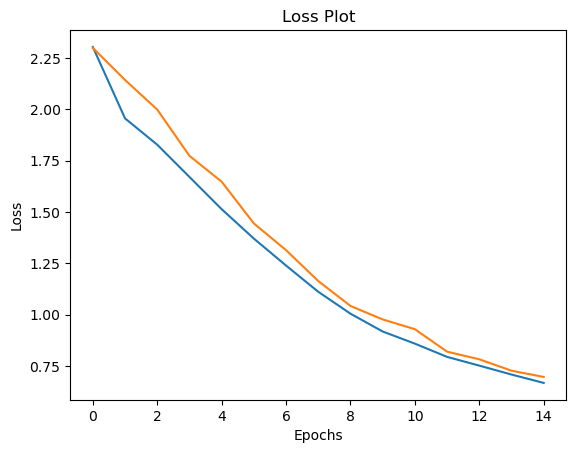

In [56]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.evaluation function using greedy search

2.evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [57]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()  #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [58]:
def beam_evaluate(image, beam_index =5): # value for beam index):

    
    max_length= max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])

    return final_caption



In [59]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [60]:
from nltk.translate.bleu_score import sentence_bleu

In [61]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [62]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [63]:
img_test=path_test.copy()

In [64]:
from gtts import gTTS
from googletrans import Translator

def translate_and_generate_audio(english_text, target_language='te'):
    # Translate the English text to the target language (Telugu in this case)
    translator = Translator()
    translated_text = translator.translate(english_text, dest=target_language).text

    # Generate audio for the translated text
    speech = gTTS(text=translated_text, lang=target_language, slow=False)

    # Save the audio file
    audio_file_name = f'voice_{target_language}.mp3'
    speech.save(audio_file_name)

    return audio_file_name, translated_text



In [78]:
def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test_d=cap_test.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    #test_image = 'Flickr8K/Images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    
    plot_attmap(result, attention_plot, test_image)
    
    target_language = 'te'
    audio_file, translated_text = translate_and_generate_audio(pred_caption, target_language)
    print(f"Translated Text telugu: {translated_text}")
    print(f"Audio file saved as: {audio_file}")
   
    

    #Let's use Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voiceeng.mp3')
   
    audio_file = 'voiceeng.mp3'
    teluguAudio_file = 'voice_te.mp3'
   
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    print("Telugu Audio")
    display.display(display.Audio(teluguAudio_file, rate=None,autoplay=autoplay))
    
    return test_image

BELU score: 100.0
Real Caption: two skateboarders
Prediction Caption: two skateboarders


ValueError: num must be 1 <= num <= 1, not 2

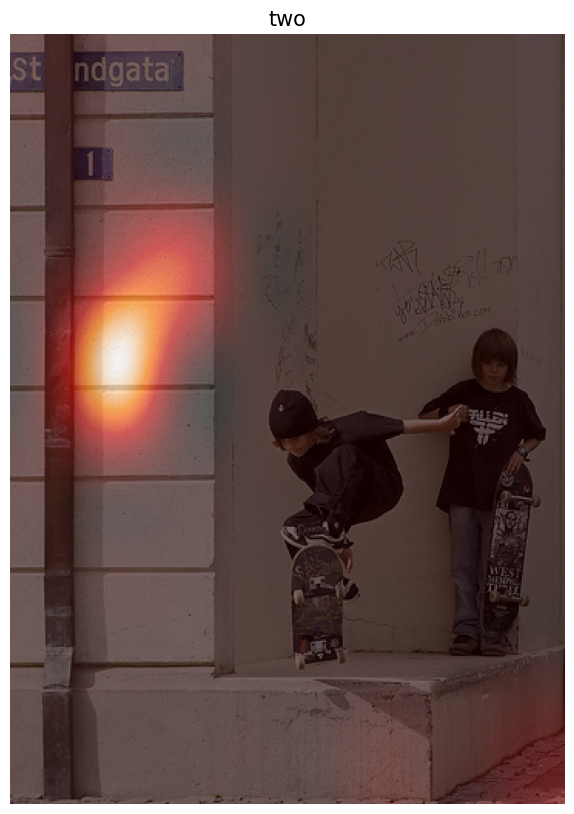

In [104]:
test_image=predicted_caption_audio(len(img_test),True,weights=(0.5,0.5,0,0))
Image.open(test_image)

BELU score: 0
Real Caption: a brown dog is running after the black dog
Prediction Caption: two dogs run in water


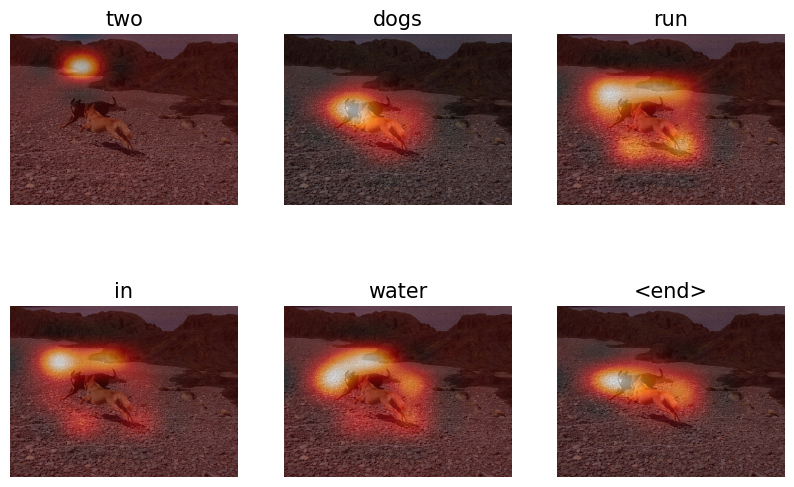

Translated Text telugu: రెండు కుక్కలు నీటిలో నడుస్తాయి
Audio file saved as: voice_te.mp3


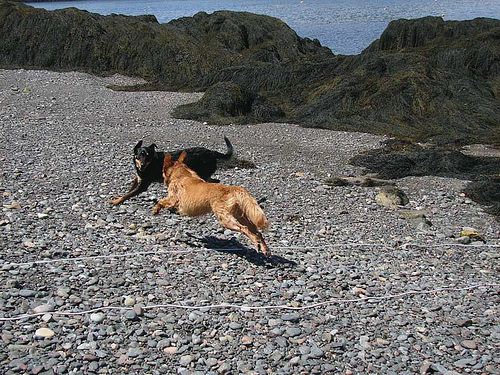

In [77]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))
Image.open(test_image)

BELU score: 19.865691534615625
Real Caption: white dog with brown ears standing near water with head turned to one side
Prediction Caption: a brown dog shakes turned to water


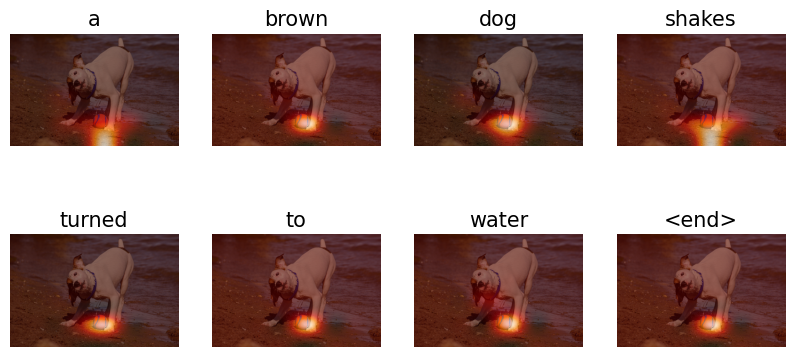

Translated Text telugu: ఒక గోధుమ కుక్క వణుకు నీటి వైపు తిరిగింది
Audio file saved as: voice_te.mp3


Telugu Audio


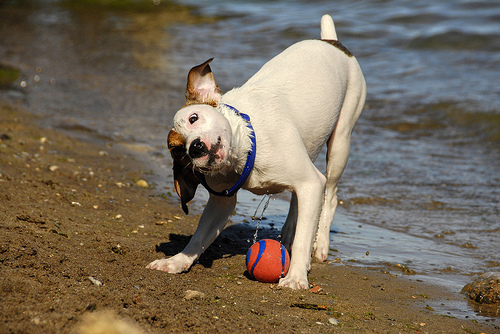

In [102]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))
Image.open(test_image)

BELU score: 63.48761284611546
Real Caption: a white dog has its head on the ground
Prediction Caption: a white dog is laying on the floor


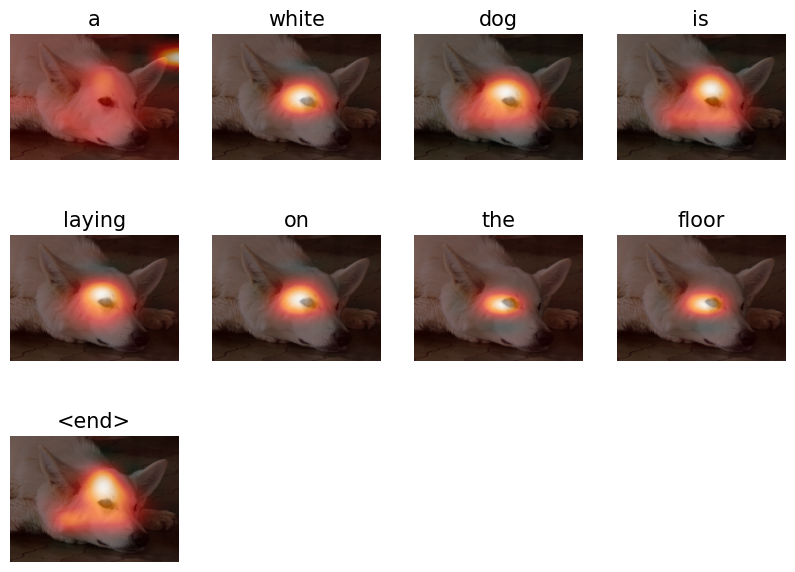

Translated Text telugu: ఒక తెల్ల కుక్క నేలపై పడుతోంది
Audio file saved as: voice_te.mp3


Telugu Audio


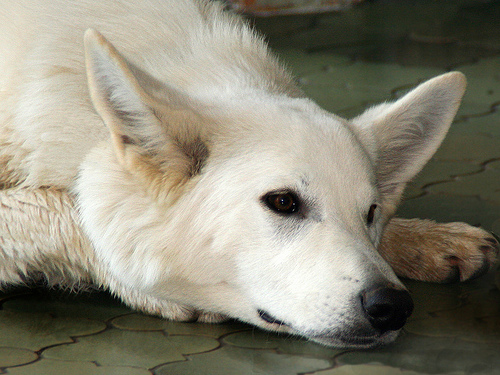

In [101]:
test_image1=predicted_caption_audio(len(img_test),False,weights=(0.25,0.25,0,0))
Image.open(test_image1)

BELU score: 14.931752645741266
Real Caption: a woman with blonde hair wearing a blue tube top is waving on the side of the street
Prediction Caption: a woman in a blue shirt appears to wait for a ride


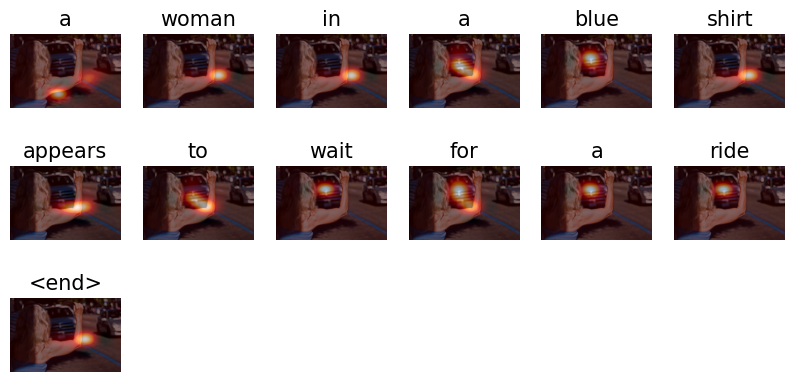

Translated Text telugu: నీలిరంగు చొక్కాలో ఉన్న ఒక మహిళ రైడ్ కోసం వేచి ఉన్నట్లు కనిపిస్తుంది
Audio file saved as: voice_te.mp3


Telugu Audio


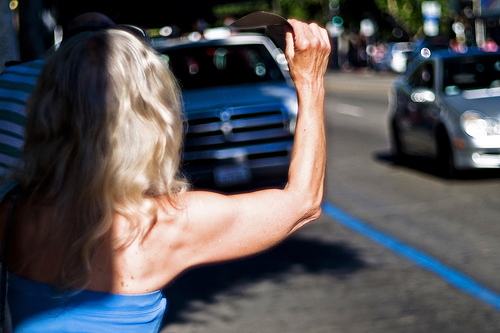

In [100]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))
Image.open(test_image)

BELU score: 100.0
Real Caption: three bikers stop in town
Prediction Caption: three bikers stop in town


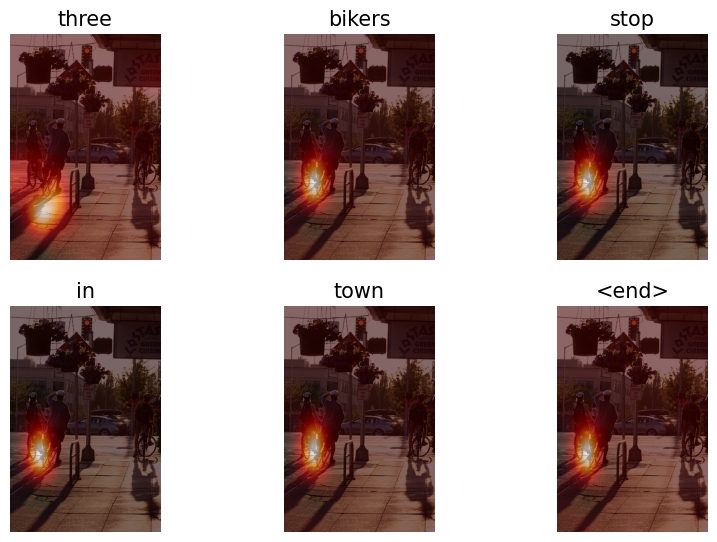

Translated Text telugu: పట్టణంలో ముగ్గురు బైకర్లు ఆగుతారు
Audio file saved as: voice_te.mp3


Telugu Audio


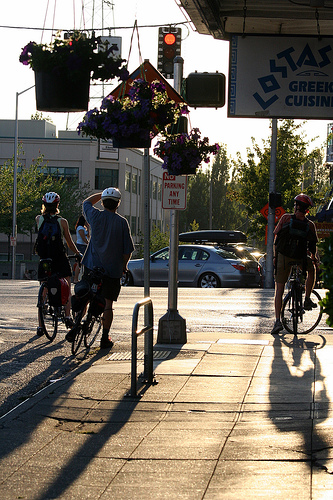

In [85]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))
Image.open(test_image)

BELU score: 10.721125348377948
Real Caption: two girls laughing outside in a yard
Prediction Caption: two girls wearing a girls are laughing in a girls are laughing in a girls are laughing in a girls are laughing in a girls are laughing in a girls


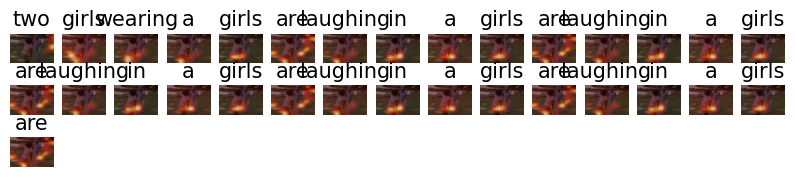

Translated Text telugu: అమ్మాయిలు ధరించిన ఇద్దరు అమ్మాయిలు అమ్మాయిలు నవ్వుతూ అమ్మాయిలు నవ్వుతూ అమ్మాయిలు నవ్వుతూ అమ్మాయిలు నవ్వుతున్నారు అమ్మాయిలలో అమ్మాయిలు నవ్వుతున్నారు
Audio file saved as: voice_te.mp3


Telugu Audio


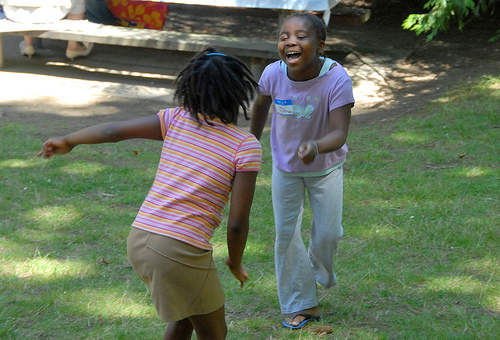

In [105]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)